In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import copy
import json
import sys
sys.path.append("../../")
from src.isoTPS.square import isoTPS
from src.models import tfi
from src.utility import utility
from src.utility import backend

# Helper functions

In [2]:
def count_matrix_sizes(log_dict):
    temp = {}
    for key, item in log_dict.items():
        key = np.prod(key)
        if key in temp:
            temp[key] += item
        else:
            temp[key] = item
    result = []
    for key, item in temp.items():
        result.append([key, item])
    if len(result) == 0:
        return None
    return np.array(result)

def produce_hist_plot_from_count_log(log_dict, ax=None, min_x=None, max_x=None, N_bins=50, density=False):
    if ax is None:
        ax = plt.gca()
    temp = count_matrix_sizes(log_dict)
    if temp is None:
        return
    if min_x is None:
        min_x = np.min(temp[:, 0])
    if max_x is None:
        max_x = np.max(temp[:, 0])
    logbins = np.geomspace(min_x, max_x, N_bins+1)
    ax.hist(np.repeat(temp[:, 0], temp[:, 1]), bins=logbins, density=density)
    ax.set_xscale("log")
    ax.set_yscale("log")

# Simulation

In [3]:
backend.log_matrix_ops = True

In [4]:
# Parameters for the isoTPS
tps_parameters = {
    # Dimensions of the lattice
    "Lx": 10,
    "Ly": 10,
    # Maximum bond dimension
    "D_max": 2,
    "chi_factor": 6,
    # Physical bond dimension
    "d": 2,
    # Options for the YB move
    "yb_options" : { 
        "mode" : "svd",
        "disentangle": True,
        "disentangle_options": {
            "mode": "renyi_approx",
            "renyi_alpha": 0.5,
            "method": "trm",
            "N_iters": 10,
        }
    },
    # Options for the TEBD algorithm
    "tebd_options": {
        "mode" : "iterate_polar",
        "N_iters": 10,
    },
    # Options for variational column optimization
    "perform_variational_column_optimization": False,
    "variational_column_optimization_options": {},
    # debug logging
    "debug_logger_options": {}
}
# TFI field and interaction strength
g = 3.5
J = 1.0
# time step for the TEBD algorithm
dt = 0.05
# number of iterations for the TEBD algorithm
N_iters_tebd = 10
# Maximum bond dimensions
D_maxs = [2, 4, 6]

In [5]:
# Create the Hamiltonian as a list of local bond operators
tfi_model = tfi.TFI(g=g, J=J)
H_bonds = tfi_model.compute_H_bonds_2D_Square(Lx=tps_parameters["Ly"], Ly=tps_parameters["Ly"])
# Compute U = e^{-dt*H}. We use 2nd order TEBD, therefore dt/2 is used as time step
U_bonds = utility.calc_U_bonds(H_bonds, dt/2)

In [6]:
Es = []
logged_matrix_ops_qr = []
logged_matrix_ops_svd = []
logged_matrix_ops_eigh = []
logged_matrix_ops_tensordot = []
logged_matrix_ops_kron = []
logged_matrix_ops_trace = []
logged_matrix_ops_dot = []
logged_matrix_ops_reshape = []
logged_matrix_ops_transpose = []

backend.reset_log_matrix_ops()

for D_max in D_maxs:
    backend.reset_log_matrix_ops()
    print(f"Performing ground state search for D_max = {D_max}.")
    start = time.time()
    # Set maximum bond dimension
    tps_parameters["D_max"] = D_max
    # Create an isoTPS with a spin-1/2 at each site and initialize it in the "all up" state.
    tps = isoTPS.isoTPS_Square(**tps_parameters)
    tps.initialize_spinup()
    # Perform TEBD
    for n in range(N_iters_tebd):
        print(f"Computing TEBD step {n}...")
        tps.perform_TEBD2(U_bonds, 1)
        Es.append(np.sum(tps.copy().compute_expectation_values_twosite(H_bonds)))
    logged_matrix_ops_qr.append(copy.deepcopy(backend.logged_matrix_ops_qr))
    logged_matrix_ops_svd.append(copy.deepcopy(backend.logged_matrix_ops_svd))
    logged_matrix_ops_eigh.append(copy.deepcopy(backend.logged_matrix_ops_eigh))
    logged_matrix_ops_tensordot.append(copy.deepcopy(backend.logged_matrix_ops_tensordot))
    logged_matrix_ops_kron.append(copy.deepcopy(backend.logged_matrix_ops_kron))
    logged_matrix_ops_trace.append(copy.deepcopy(backend.logged_matrix_ops_trace))
    logged_matrix_ops_dot.append(copy.deepcopy(backend.logged_matrix_ops_dot))
    logged_matrix_ops_reshape.append(copy.deepcopy(backend.logged_matrix_ops_reshape))
    logged_matrix_ops_transpose.append(copy.deepcopy(backend.logged_matrix_ops_transpose))
    end = time.time()

    print(f"Took {round(end-start, 3)} seconds.")

Performing ground state search for D_max = 2.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 302.3 seconds.
Performing ground state search for D_max = 4.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 3644.986 seconds.
Performing ground state search for D_max = 6.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 47182.692 seconds.


In [7]:
n = 1
print("qr:", len(logged_matrix_ops_qr[n]))
print("svd:", len(logged_matrix_ops_svd[n]))
print("eigh:", len(logged_matrix_ops_eigh[n]))
print("tensordot:", len(logged_matrix_ops_tensordot[n]))
print("kron:", len(logged_matrix_ops_kron[n]))
print("trace:", len(logged_matrix_ops_trace[n]))
print("dot:", len(logged_matrix_ops_dot[n]))
print("reshape:", len(logged_matrix_ops_reshape[n]))
print("transpose:", len(logged_matrix_ops_transpose[n]))


qr: 80
svd: 13
eigh: 8
tensordot: 94
kron: 0
trace: 4
dot: 40
reshape: 324
transpose: 308


In [28]:
def keys_to_strings(d):
    if isinstance(d, dict):
        result = {}
        for key, value in d.items():
            result[str(key)] = keys_to_strings(value)
        return result
    elif isinstance(d, list):
        return [keys_to_strings(element) for element in d]
    else:
        return d

with open("temp/matrix_ops_count_qr_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_qr), file)
with open("temp/matrix_ops_count_svd_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_svd), file)
with open("temp/matrix_ops_count_eigh_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_eigh), file)
with open("temp/matrix_ops_count_tensordot_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_tensordot), file)
with open("temp/matrix_ops_count_kron_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_kron), file)
with open("temp/matrix_ops_count_trace_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_trace), file)
with open("temp/matrix_ops_count_dot_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_dot), file)
with open("temp/matrix_ops_count_reshape_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_reshape), file)
with open("temp/matrix_ops_count_transpose_chi_factor_6.json", "w") as file:
    json.dump(keys_to_strings(logged_matrix_ops_transpose), file)

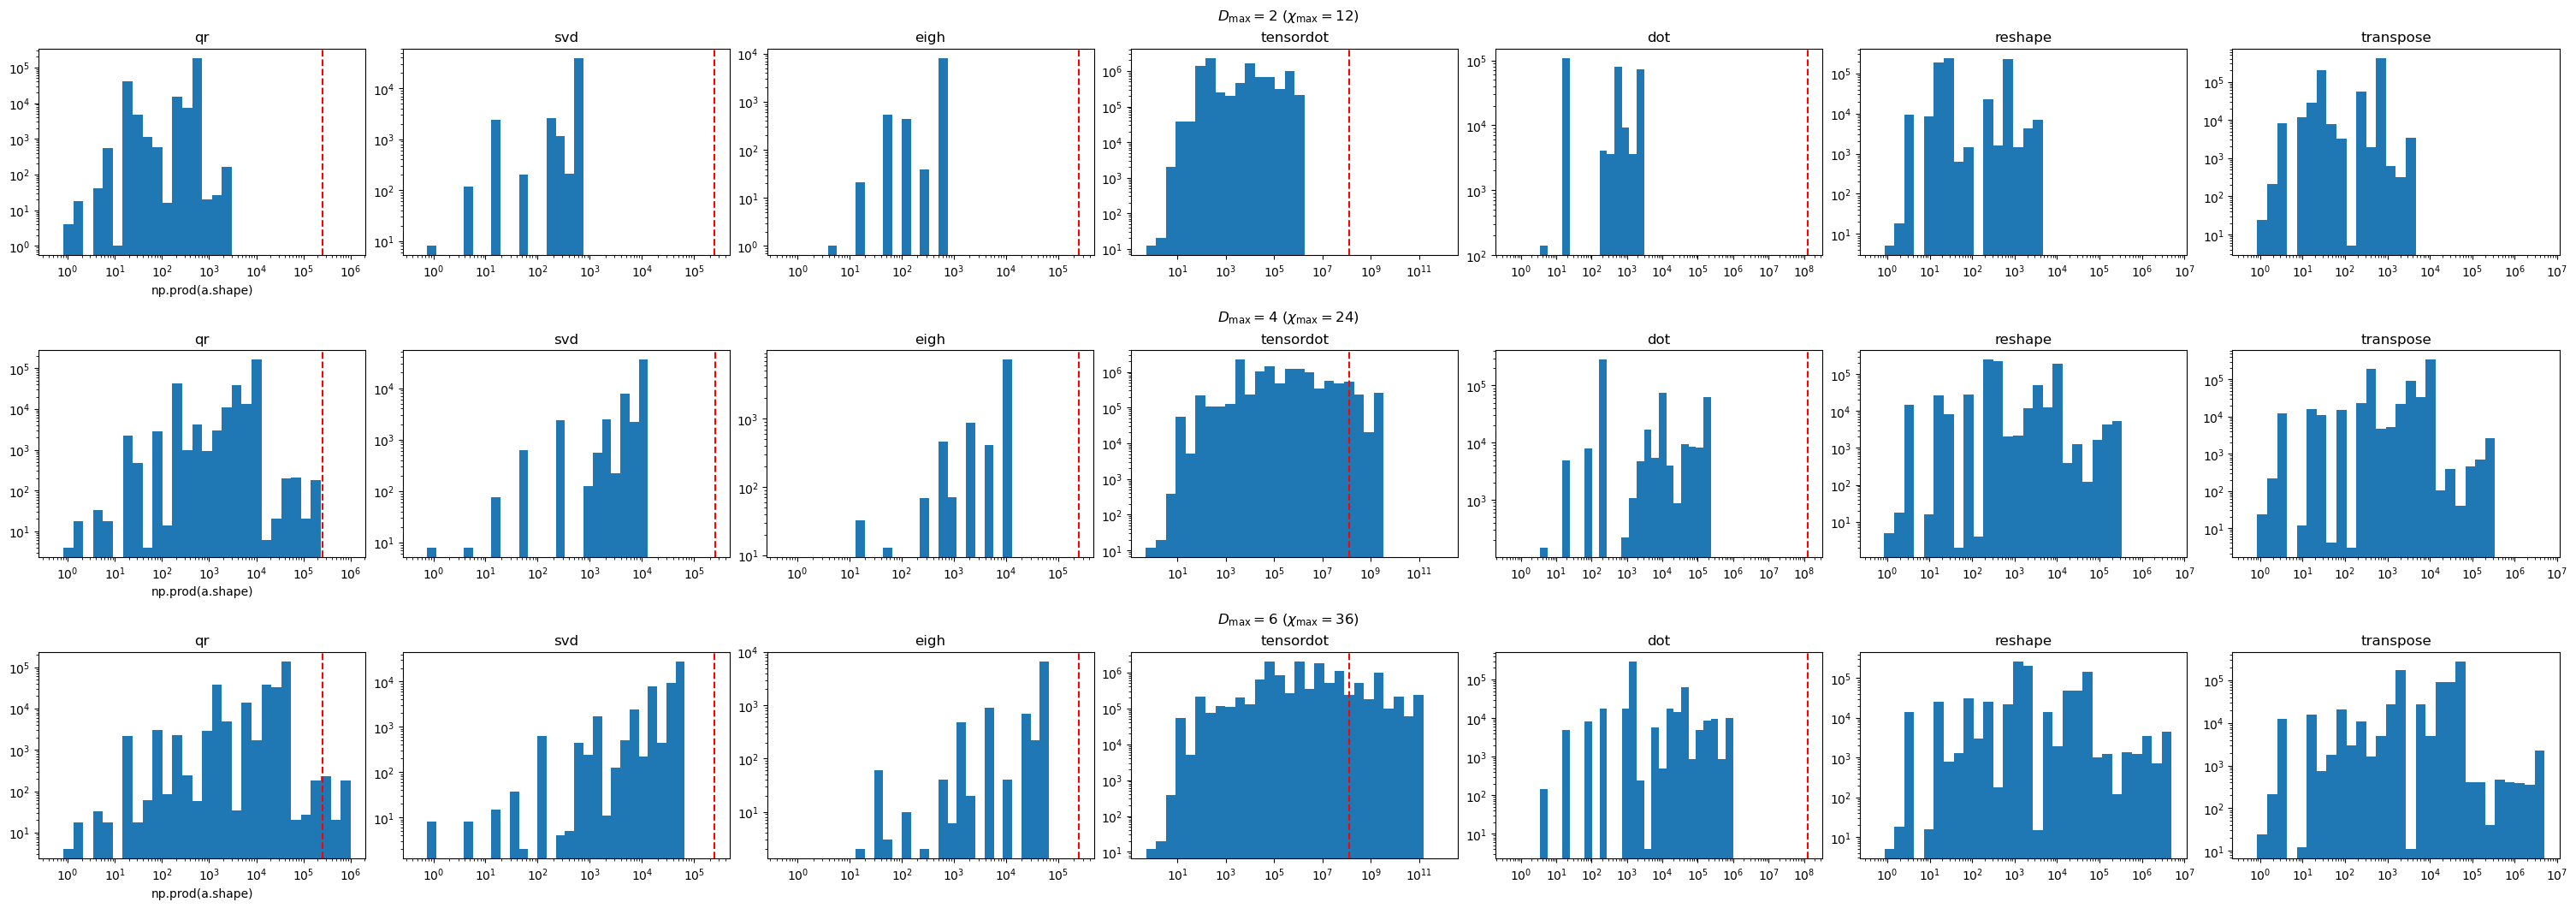

In [12]:
#fig, axarray = plt.subplots(len(D_maxs), 7, figsize=(20, len(D_maxs)*2))

fig = plt.figure(constrained_layout=True, figsize=(30, len(D_maxs)*3.5))
subfigs = fig.subfigures(len(D_maxs), 1)
axarray = [subfig.subplots(1, 7) for subfig in subfigs]

xlim_qr = (5e-1, 1e6)
xlim_svd = (5e-1, 1e5)
xlim_eigh = (5e-1, 1e5)
xlim_tensordot = (5e-1, 1e12)
xlim_dot = (5e-1, 1e6)
xlim_reshape = (5e-1, 5e6)
xlim_transpose = (5e-1, 5e6)

N_bins = 30
density = False

matrix_multiplication_threshhold = 500**3
linalg_op_threshhold = 500**2

for n, D_max in enumerate(D_maxs):
    produce_hist_plot_from_count_log(logged_matrix_ops_qr[n], ax=axarray[n][0], min_x=xlim_qr[0], max_x=xlim_qr[1], N_bins=N_bins, density=density)
    axarray[n][0].set_title("qr")
    axarray[n][0].axvline(linalg_op_threshhold, color="red", ls="--")
    axarray[n][0].set_xlabel(r"np.prod(a.shape)")
    produce_hist_plot_from_count_log(logged_matrix_ops_svd[n], ax=axarray[n][1], min_x=xlim_svd[0], max_x=xlim_svd[1], N_bins=N_bins, density=density)
    axarray[n][1].axvline(linalg_op_threshhold, color="red", ls="--")
    axarray[n][0].set_xlabel(r"np.prod(a.shape)")
    axarray[n][1].set_title("svd")
    produce_hist_plot_from_count_log(logged_matrix_ops_eigh[n], ax=axarray[n][2], min_x=xlim_eigh[0], max_x=xlim_eigh[1], N_bins=N_bins, density=density)
    axarray[n][2].axvline(linalg_op_threshhold, color="red", ls="--")
    axarray[n][0].set_xlabel(r"np.prod(a.shape)")
    axarray[n][2].set_title("eigh")
    produce_hist_plot_from_count_log(logged_matrix_ops_tensordot[n], ax=axarray[n][3], min_x=xlim_tensordot[0], max_x=xlim_tensordot[1], N_bins=N_bins, density=density)
    axarray[n][3].axvline(matrix_multiplication_threshhold, color="red", ls="--")
    axarray[n][0].set_xlabel(r"a.shape[0]*a.shape[1]*b.shape[1]")
    axarray[n][3].set_title("tensordot")
    produce_hist_plot_from_count_log(logged_matrix_ops_dot[n], ax=axarray[n][4], min_x=xlim_dot[0], max_x=xlim_dot[1], N_bins=N_bins, density=density)
    axarray[n][4].axvline(matrix_multiplication_threshhold, color="red", ls="--")
    axarray[n][0].set_xlabel(r"a.shape[0]*a.shape[1]*b.shape[1]")
    axarray[n][4].set_title("dot")
    produce_hist_plot_from_count_log(logged_matrix_ops_reshape[n], ax=axarray[n][5], min_x=xlim_reshape[0], max_x=xlim_reshape[1], N_bins=N_bins, density=density)
    axarray[n][5].set_title("reshape")
    axarray[n][0].set_xlabel(r"np.prod(a.shape)")
    produce_hist_plot_from_count_log(logged_matrix_ops_transpose[n], ax=axarray[n][6], min_x=xlim_transpose[0], max_x=xlim_transpose[1], N_bins=N_bins, density=density)
    axarray[n][6].set_title("transpose")
    axarray[n][0].set_xlabel(r"np.prod(a.shape)")
    subfigs[n].suptitle(r"$D_\text{max} = "+str(D_max)+r"$ ($\chi_\text{max} = "+str(tps_parameters["chi_factor"]*D_max)+r"$)")

plt.savefig("count_matrix_operations_chi_factor_6.pdf")
plt.show()